In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 1. FETCHING DATA

In [3]:
base_url = "http://localhost:5000"


def fetch_data(endpoint):
    response = requests.get(f"{base_url}/{endpoint}")
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data from {endpoint}")

# Fetch data
vehicles_data = fetch_data('vehicles')
drivers_data = fetch_data('drivers')
trips_data = fetch_data('trips')
routes_data = fetch_data('routes')

# 2. DATA PRE-PROSESSING & CLEANING

In [5]:
# Convert raw data into pandas DataFrame
vehicles_df = pd.DataFrame(vehicles_data)
drivers_df = pd.DataFrame(drivers_data)
trips_df = pd.DataFrame(trips_data)
routes_df = pd.DataFrame(routes_data)

# Convert date columns to datetime type (example: maintenance date, trip start time)
vehicles_df['last_maintenance_date'] = pd.to_datetime(vehicles_df['last_maintenance_date'])
trips_df['start_time'] = pd.to_datetime(trips_df['start_time'])
trips_df['end_time'] = pd.to_datetime(trips_df['end_time'], errors='coerce')

# Handle missing values - example: filling nulls with appropriate strategies
vehicles_df.fillna({'fuel_efficiency': vehicles_df['fuel_efficiency'].median()}, inplace=True)
trips_df.fillna({'actual_duration': trips_df['expected_duration']}, inplace=True)
routes_df.fillna({'historical_delays': routes_df['historical_delays'].median()}, inplace=True)

# Drop columns that are not relevant for the analysis
trips_df.drop(columns=['delay_reason', 'incidents_reported'], inplace=True)

# Handle categorical variables (encoding if necessary)
drivers_df['certifications'] = drivers_df['certifications'].apply(lambda x: eval(x))  # Convert string list to actual list


# 3. DATA EXPLORATION

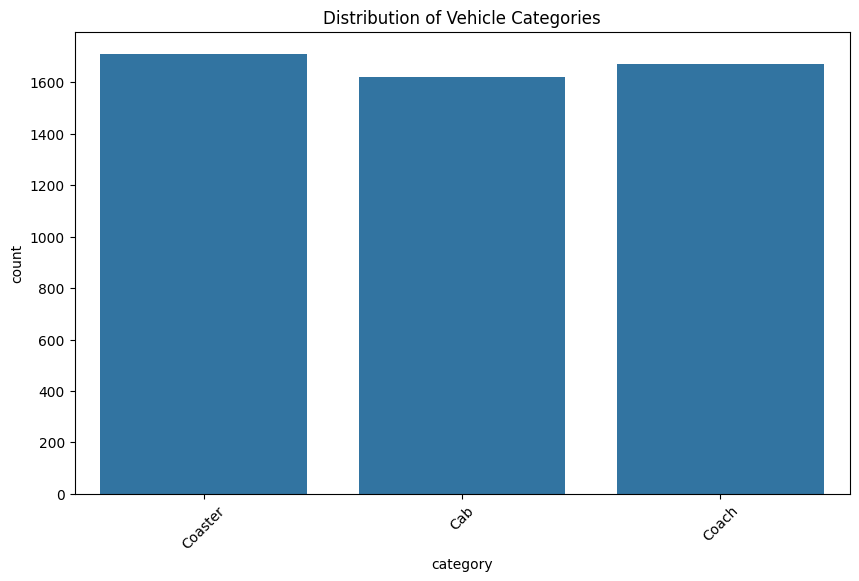

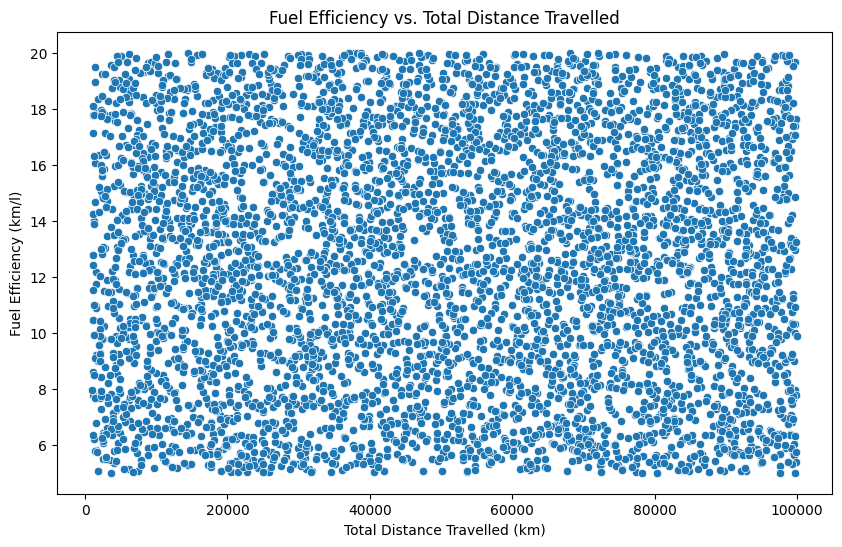

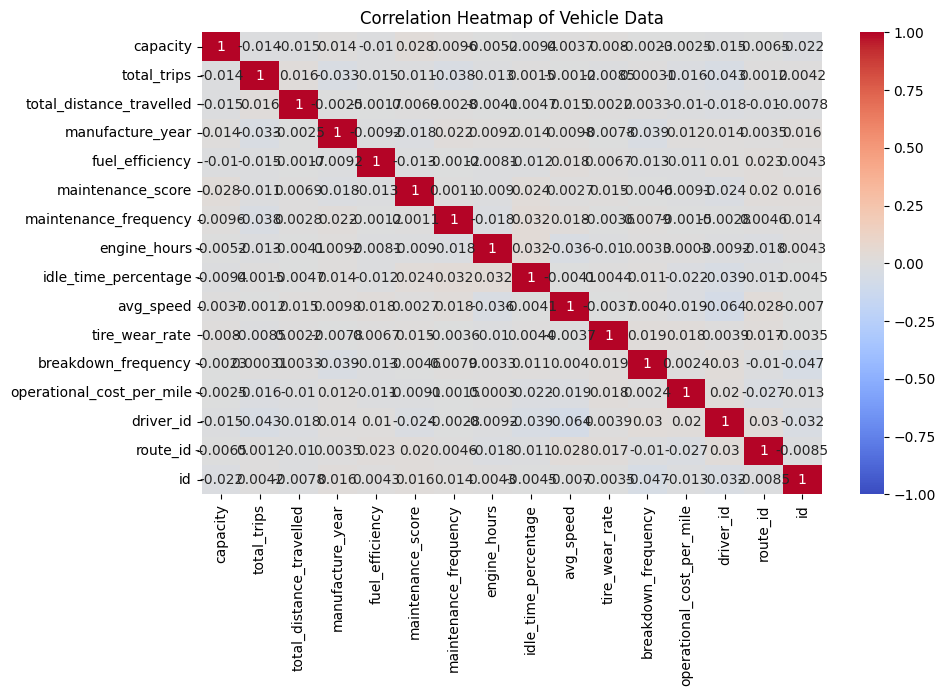

In [6]:
# Example: Plot the distribution of vehicle categories
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=vehicles_df)
plt.title('Distribution of Vehicle Categories')
plt.xticks(rotation=45)
plt.show()

# Plot fuel efficiency vs. total distance travelled
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_distance_travelled', y='fuel_efficiency', data=vehicles_df)
plt.title('Fuel Efficiency vs. Total Distance Travelled')
plt.xlabel('Total Distance Travelled (km)')
plt.ylabel('Fuel Efficiency (km/l)')
plt.show()

# Correlation heatmap for numerical variables
numeric_cols = vehicles_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = vehicles_df[numeric_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Vehicle Data')
plt.show()


# 4. SAVE CLEANED DATA TO CSV

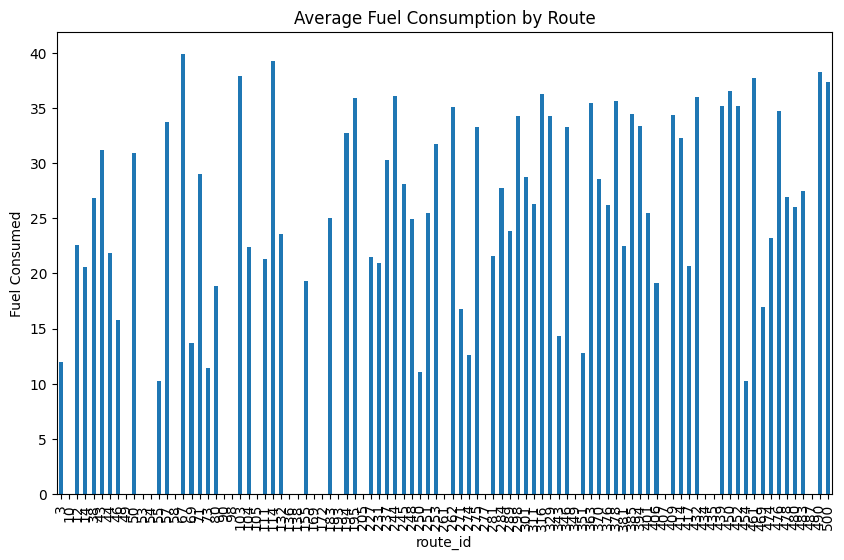

In [7]:
vehicles_df.to_csv('csv_datasets/vehicles_cleaned.csv', index=False)
drivers_df.to_csv('csv_datasets/drivers_cleaned.csv', index=False)
trips_df.to_csv('csv_datasets/trips_cleaned.csv', index=False)
routes_df.to_csv('csv_datasets/routes_cleaned.csv', index=False)

# 5. Further exploration (optional)
# For example, checking out the average fuel consumption by route or driver
avg_fuel_by_route = trips_df.groupby('route_id')['fuel_consumed'].mean()
avg_fuel_by_route.plot(kind='bar', figsize=(10, 6), title="Average Fuel Consumption by Route")
plt.ylabel('Fuel Consumed')
plt.show()

# 5. MERGE DATASETS

In [8]:
vehicles_df = pd.read_csv('csv_datasets/vehicles_cleaned.csv')
drivers_df = pd.read_csv('csv_datasets/drivers_cleaned.csv')
trips_df = pd.read_csv('csv_datasets/trips_cleaned.csv')
routes_df = pd.read_csv('csv_datasets/routes_cleaned.csv')

# Merge all the four datasets in reversed order
merged_df = pd.merge(routes_df, trips_df, left_on='id', right_on='route_id', how='inner')
merged_df = pd.merge(merged_df, drivers_df, left_on='driver_id', right_on='id', how='inner', suffixes=('_trips', '_drivers'))
merged_df = pd.merge(merged_df, vehicles_df, left_on='vehicle_id', right_on='id', how='inner', suffixes=('_merged', '_vehicles'))

merged_df = merged_df.rename(columns={
    'driver_id_merged': 'driver_id',
    'route_id_merged': 'route_id',
    'total_trips_vehicles': 'total_trips_vehicle',
    'total_trips_merged': 'total_trips_driver',
})

merged_df.to_csv('csv_datasets/merged_dataset.csv', index=False)
merged_df


,route_code,cost,start_location,end_location,estimated_travel_time,distance,avg_traffic_density,avg_fuel_consumption,historical_delays,weather_risk_factor,...,idle_time_percentage,avg_speed,emissions_data,tire_wear_rate,breakdown_frequency,sensor_data_json,operational_cost_per_mile,driver_id_vehicles,route_id_vehicles,id_vehicles
0,R003,297.859435,Kibuye,Huye,8 hours,197.216279,0.626192,22.193856,30.586986,0.795681,...,0.062922,43.066863,"{""co2"": 293.3549015211976, ""nox"": 27.477389328...",0.003717,0.037235,"{""engine_temp"": 218.5859586542421, ""oil_pressu...",0.599346,622.0,227.0,856
1,R010,479.650035,Rwamagana,Gisenyi,3 hours,88.477589,0.700221,26.325266,15.690178,0.234448,...,0.268414,32.742960,"{""co2"": 131.69945587342872, ""nox"": 24.50981804...",0.002652,0.030136,"{""engine_temp"": 200.42776268825125, ""oil_press...",0.692797,770.0,103.0,989
2,R012,126.320665,Gicumbi,Kamonyi,1 hours,365.251617,0.293112,12.458776,40.932399,0.401980,...,0.103769,54.919210,"{""co2"": 234.11395160668528, ""nox"": 15.88562088...",0.005728,0.027438,"{""engine_temp"": 191.05866874701485, ""oil_press...",0.913133,573.0,NaN,962
3,R014,248.698645,Kirehe,Rwamagana,9 hours,423.393173,0.138597,10.268256,50.440608,0.682111,...,0.144147,53.019477,"{""co2"": 137.71491629369814, ""nox"": 31.75411176...",0.007362,0.027907,"{""engine_temp"": 189.9104211554632, ""oil_pressu...",0.866766,959.0,NaN,382
4,R038,181.187621,Karongi,Nyanza,9 hours,86.289378,0.677655,28.465152,50.015062,0.652263,...,0.134862,32.879384,"{""co2"": 104.9216827061268, ""nox"": 23.667635040...",0.006753,0.044655,"{""engine_temp"": 219.29315350445265, ""oil_press...",0.849128,557.0,139.0,831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,R480,472.649542,Karongi,Nyundo,7 hours,179.679516,0.240311,19.296221,25.716907,0.458181,...,0.106769,55.064580,"{""co2"": 102.54300887637291, ""nox"": 37.96099706...",0.002304,0.020024,"{""engine_temp"": 191.23845268839943, ""oil_press...",1.291862,150.0,285.0,422
96,R483,152.933856,Butare,Kirehe,7 hours,109.842402,0.214840,23.914699,3.254365,0.676908,...,0.249165,44.419586,"{""co2"": 284.2228591970461, ""nox"": 21.198737923...",0.005896,0.019350,"{""engine_temp"": 181.27583079648852, ""oil_press...",0.629422,842.0,NaN,78
97,R487,499.205537,Kamonyi,Gisenyi,6 hours,364.799111,0.755715,15.471993,48.234328,0.458665,...,0.152870,41.256807,"{""co2"": 136.0584790771425, ""nox"": 29.947873040...",0.009903,0.047159,"{""engine_temp"": 195.38561512315655, ""oil_press...",1.583538,441.0,111.0,606
98,R490,441.781457,Huye,Gicumbi,1 hours,354.603976,0.591722,28.775757,23.769158,0.655600,...,0.287485,57.859845,"{""co2"": 104.08794389827905, ""nox"": 43.66395969...",0.005451,0.045249,"{""engine_temp"": 195.41709495667385, ""oil_press...",0.686500,548.0,489.0,75
